In [1]:
from datasets import *
from torch.utils.data import DataLoader
import json
from PIL import Image
import random
from e2c_model import E2C
from torchvision.transforms import ToTensor
import gym
import copy
import matplotlib.pyplot as plt

In [2]:
def rgb2bw(img):
    #thresh = 200
    width = int(48*2)
    height = 48
    pil_image = Image.fromarray(img)
    img_bw = pil_image.convert('L').resize((int(width/2),height)).point(lambda x: 0 if x < 128 else 255, '1')

    return np.array(img_bw)

In [196]:
rt_path = './data/pendulum'
with open(path.join(rt_path, 'data.json')) as f:
    data = json.load(f)

In [197]:
for sample in random.sample(data['samples'],1):
    before = Image.open(os.path.join(rt_path, sample['before'])).convert('L').resize((GymPendulumDatasetV2.width,
                                   GymPendulumDatasetV2.height)).point(lambda x: 0 if x<128 else 255, '1')
    before_state = sample['before_state']
    u = np.array(sample['control'])
    after = Image.open(os.path.join(rt_path, sample['after'])).convert('L').resize((GymPendulumDatasetV2.width,
                                   GymPendulumDatasetV2.height)).point(lambda x: 0 if x<128 else 255, '1')
    after_state = sample['after_state']
    break

before_angle = 3.287712
[1.84718354]
after_angle = 3.249569


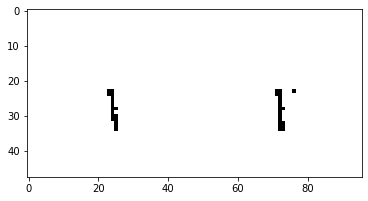

In [198]:
print('before_angle = %f' %before_state[0])
plt.imshow(before)
print(u)
print('after_angle = %f' %after_state[0])

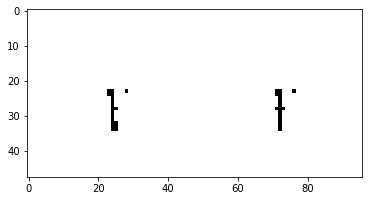

In [199]:
plt.imshow(after)

[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255   0   0 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255   0
   0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255]


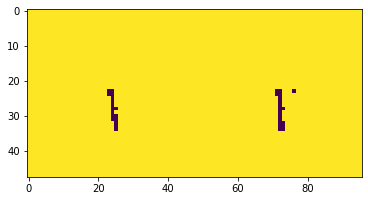

In [200]:
before = Image.open(os.path.join(rt_path, sample['before']))
before = Image.open(os.path.join(rt_path, sample['before'])).convert('L').point(lambda x: 0 if x<128 else 255)
plt.imshow(before)
print(np.array(before)[24])

## Model

In [3]:
device = torch.device("cuda")
w = int(48*2)
h = 48
settings = {'planar': (1600, 2, 2), 'pendulum': (4608, 3, 1)}
obs_dim, z_dim, u_dim = settings['pendulum']
env_name = 'pendulum'
model = E2C(obs_dim=obs_dim, z_dim=z_dim, u_dim=u_dim, env=env_name, device='cuda').to(device)
model.load_state_dict(torch.load('./model/model_1000.pth'))
model.eval()

E2C(
  (encoder): PendulumEncoder(
    (net): Sequential(
      (0): Linear(in_features=4608, out_features=800, bias=True)
      (1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=800, out_features=800, bias=True)
      (4): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=800, out_features=6, bias=True)
    )
  )
  (decoder): PendulumDecoder(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=800, bias=True)
      (1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=800, out_features=800, bias=True)
      (4): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=800, out_features=4608, bias=True)
      (7): Sigmoid()
    )
  )
  (trans): PendulumTransit

In [202]:
# Transform PIL image to tensor 
# $ ToTensor()(PIL image)
x = ToTensor()(before).view(-1, model.obs_dim).double().to(device)
u = torch.FloatTensor(u).double().unsqueeze(0).to(model.device)
# u = u.double().to(device)
# u = torch.FloatTensor(u).to(model.device).double().unsqueeze(0)

x_next = ToTensor()(after).view(-1, model.obs_dim).double().to(device)

x_recon, x_next_pred, q_z, q_z_next_pred, q_z_next = model(x, u, x_next)

In [203]:
x_recon = x_recon.detach().cpu().numpy()
x = x.cpu().numpy()

x_next_pred = x_next_pred.detach().cpu().numpy()
x_next = x_next.cpu().numpy()

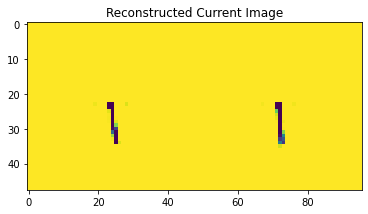

In [204]:
plt.title('Reconstructed Current Image')
plt.imshow(x_recon.reshape(h,w))

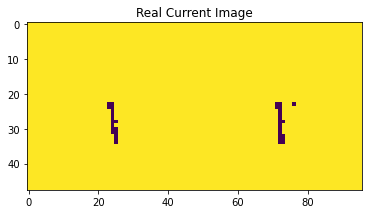

In [205]:
plt.title('Real Current Image')
plt.imshow(x.reshape(h,w))

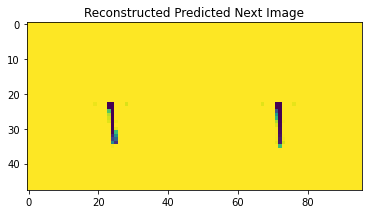

In [206]:
plt.title('Reconstructed Predicted Next Image')
plt.imshow(x_next_pred.reshape(h,w))

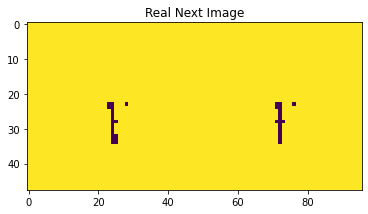

In [207]:
plt.title('Real Next Image')
plt.imshow(x_next.reshape(h,w))

In [208]:
x = ToTensor()(before).view(-1, model.obs_dim).double().to(device)
mu, logvar = model.encode(x)
print(mu, logvar)

tensor([[-0.0620, -0.7410, -1.7681]], device='cuda:0',
       grad_fn=<SplitBackward0>) tensor([[-6.2497, -6.5771, -3.2690]], device='cuda:0',
       grad_fn=<SplitBackward0>)


## Env Simulation

In [218]:
env = gym.make('Pendulum-v1')
env = env.unwrapped # use this to change gym.env state manually
env.reset()

def rgb2bw(img):
    #thresh = 200
    width = int(48*2)
    height = 48
    pil_image = Image.fromarray(img)
    img_bw = pil_image.convert('L').resize((int(width/2),height)).point(lambda x: 0 if x < 128 else 255, '1') # option '1' make image return bool value

    return np.array(img_bw)

device = torch.device("cuda")

# initialize model
w = int(48*2)
h = 48
settings = {'planar': (1600, 2, 2), 'pendulum': (4608, 3, 1)}
obs_dim, z_dim, u_dim = settings['pendulum']
env_name = 'pendulum'
model = E2C(obs_dim=obs_dim, z_dim=z_dim, u_dim=u_dim, env=env_name, device="cuda").to(device)
model.load_state_dict(torch.load('./model/model_1000.pth'))
model.eval()

u = np.random.uniform(-2,2,1)
prev_img = rgb2bw(env.render(mode='rgb_array'))
_ = env.step(u)
cur_img = rgb2bw(env.render(mode='rgb_array'))

start_img = Image.fromarray(np.hstack((prev_img, cur_img)))
start_img = ToTensor()((start_img.convert('L').resize((w,h))).point(lambda x: 0 if x < 128 else 255, '1'))
#print(start_img.shape)
#print('start_img = ', start_img[0][24])
start_img = start_img.view(-1, model.obs_dim).double().to(device)
#print('start_img = ', start_img[0])
#print(torch.sum(start_img))

''' # wrong image processing
(may be because, train was performend on image that has value (0 or 1),
but this processing returns image value to be (0 or 255))

start_img1 = np.hstack((prev_img, cur_img)).reshape(-1, model.obs_dim)
#print(start_img[0][0])
start_img1 = torch.FloatTensor(start_img1).double().to(device)
#print('start_img1 = ', start_img1[0])  #output True to 255, don't know why. maybe due to 'point' part in function rgb2bw
#print(torch.sum(start_img1))
'''

# To check whether model produces normal result, data and model are well matched 
mu_z, logvar_z = model.encode(start_img)
#z = mu_z   # use mean of distribution of encoding and transition for optimal control in latent space
z = model.reparam(mu_z, logvar_z)
print('mu & logvar = ', mu_z, logvar_z)
print('z = ', z)
# x_recon = model.decode(z)
# plt.imshow(x_recon.cpu().detach().numpy().reshape(h,w))

T = 20    # prediction length(not exact)
env_imgs = [copy.deepcopy(prev_img), copy.deepcopy(cur_img)]
us = np.zeros((T+1,1))
us[0] = u

for i in range(T):
    u = np.random.uniform(-2,2,1)
    us[i+1] = u
    _ = env.step(u)
    cur_img = rgb2bw(env.render(mode='rgb_array'))
    env_imgs.append(copy.deepcopy(cur_img))

# produce better performance when using first image to real image
# rather than using reconstructed image from latent space
#x = model.decode(z) # x_recon.shape = torch.Size([1, 4608])
#x_recon = x.cpu().detach().numpy()[0]
x = start_img
original_img = x.cpu().detach().numpy()[0]

predicted_imgs = [original_img]
for i in range(T+1):
    u = us[i]
    u = torch.FloatTensor(u).double().unsqueeze(0).to(model.device)
    
    x_next_pred = model.predict(x, u)
    predicted_img = x_next_pred.cpu().detach().numpy()[0]
    predicted_imgs.append(predicted_img)
    
    x = x_next_pred
    
env.close()

mu & logvar =  tensor([[ 0.5400, -2.3280,  0.2536]], device='cuda:0',
       grad_fn=<SplitBackward0>) tensor([[-5.7836, -3.1590, -5.8505]], device='cuda:0',
       grad_fn=<SplitBackward0>)
z =  tensor([[ 0.4688, -2.5248,  0.2459]], device='cuda:0', grad_fn=<AddBackward0>)


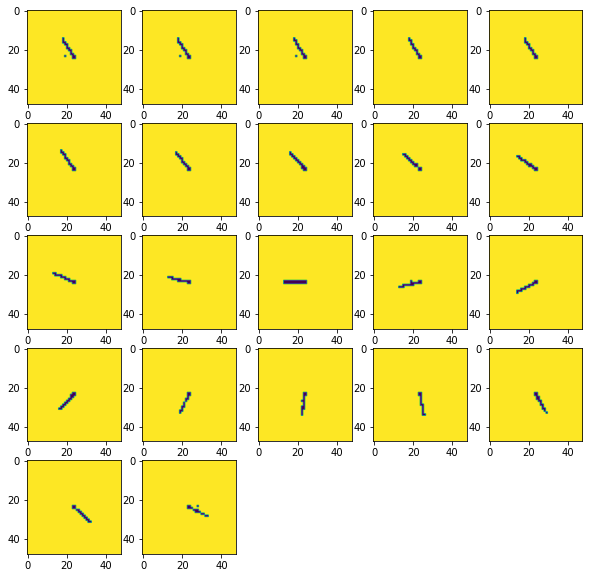

In [219]:
# Real image
plt.figure(figsize=(10,10))
for i in range(T+2):
    plt.subplot(5,5,i+1)
    plt.imshow(env_imgs[i])

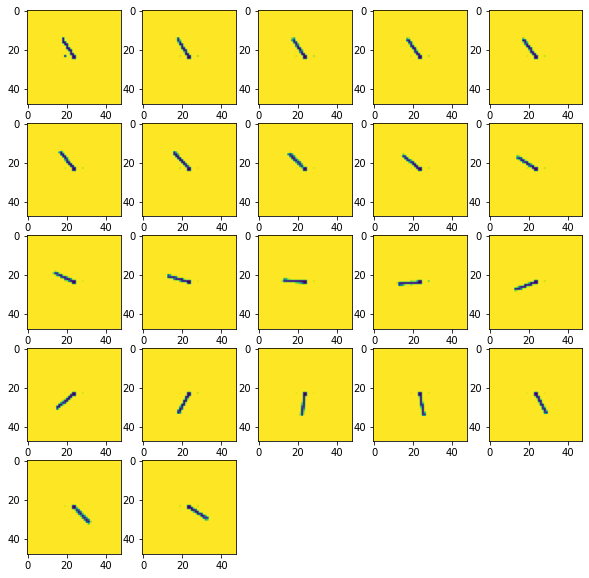

In [220]:
# Reconstruacted predcited image on latent space
plt.figure(figsize=(10,10))
for i in range(T+2):
    plt.subplot(5,5,i+1)
    plt.imshow(predicted_imgs[i].reshape(h,w)[:,:int(w/2)])

## Checking O_t value in transition network

In [209]:
env = gym.make('Pendulum-v1')
env = env.unwrapped # use this to change gym.env state manually
env.reset()

def rgb2bw(img):
    #thresh = 200
    width = int(48*2)
    height = 48
    pil_image = Image.fromarray(img)
    img_bw = pil_image.convert('L').resize((int(width/2),height)).point(lambda x: 0 if x < 128 else 255, '1') # option '1' make image return bool value

    return np.array(img_bw)

u = np.random.uniform(-2,2,1)
prev_img = rgb2bw(env.render(mode='rgb_array'))
_ = env.step(u)
cur_img = rgb2bw(env.render(mode='rgb_array'))

start_img = Image.fromarray(np.hstack((prev_img, cur_img)))
start_img = ToTensor()((start_img.convert('L').resize((w,h))).point(lambda x: 0 if x < 128 else 255, '1'))
x = start_img.view(-1, model.obs_dim).double().to(device)

mu, logvar = model.encode(x)
z = model.reparam(mu, logvar)
h_t = model.trans.net(z)
o_t = model.trans.fc_o(h_t)
print('o_t = ', o_t)

env.close()

o_t =  tensor([[0.4096, 0.6400, 0.3341]], device='cuda:0', grad_fn=<AddmmBackward0>)


## Env experiment

In [1]:
env = gym.make('Pendulum-v1')
env = env.unwrapped
env.reset()

width, height = 48 * 2, 48
true_x_history = []
recon_x_history = []
pred_x_history = []
T = 5 # history length

device = torch.device("cuda")

for i in range(T):
    # cur_state = env.state
    cur_img = env.render(mode = 'rgb_array') # return numpy.ndarray
    cur_arr = rgb2bw(cur_img)
    
    action = np.random.uniform(-2, 2, size = 1)
    _ = env.step(action)
    
    # next_state = env.state
    next_img = env.render(mode = 'rgb_array') # return numpy.ndarray
    next_arr = rgb2bw(next_img)
    
    _ = env.step(action)
    
    # nnext_state = env.state
    nnext_img = env.render(mode = 'rgb_array') # return numpy.ndarray
    nnext_arr = rgb2bw(nnext_img)
    
    cur_x = np.hstack((cur_arr, next_arr)).reshape((-1, width*height))
    next_x = np.hstack((next_arr, nnext_arr)).reshape((-1, width*height))
    
    x = torch.tensor(cur_x, dtype=torch.float64).to(device)
    x_next = torch.tensor(next_x, dtype=torch.float64).to(device)
    u = u.double().to(device)
    
    x_recon, x_next_pred, q_z, q_z_next_pred, q_z_next = model(x, u, x_next)
    
    x_recon.view(w, h)
    x_recon = x_recon.detach().cpu().numpy()
    x_next_pred.view(w, h)
    x_next_pred = x_next_pred.detach().cpu().numpy()
    
    true_x_history.append(np.hstack((cur_arr, next_arr)))
    recon_x_history.append(x_recon)
    pred_x_history.append(x_next_pred)
    
env.close()

NameError: name 'gym' is not defined

## Checking O_t value

In [5]:
env = gym.make('Pendulum-v1')
env = env.unwrapped # use this to change gym.env state manually
env.reset()

def rgb2bw(img):
    #thresh = 200
    width = int(48*2)
    height = 48
    pil_image = Image.fromarray(img)
    img_bw = pil_image.convert('L').resize((int(width/2),height)).point(lambda x: 0 if x < 128 else 255, '1') # option '1' make image return bool value

    return np.array(img_bw)

u = np.random.uniform(-2,2,1)
prev_img = rgb2bw(env.render(mode='rgb_array'))
_ = env.step(u)
cur_img = rgb2bw(env.render(mode='rgb_array'))

start_img = Image.fromarray(np.hstack((prev_img, cur_img)))
start_img = ToTensor()((start_img.convert('L').resize((w,h))).point(lambda x: 0 if x < 128 else 255, '1'))
x = start_img.view(-1, model.obs_dim).double().to(device)

mu, logvar = model.encode(x)
z = model.reparam(mu, logvar)
h_t = model.trans.net(z)
o_t = model.trans.fc_o(h_t)
print('o_t = ', o_t)

env.close()

o_t =  tensor([[-0.3855,  0.6319,  0.8977]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
